## Libs

In [63]:
import numpy as np
import pandas as pd
import psycopg2
import json
import time
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Database connection

In [64]:
DB_NAME = 'templatedb'
DB_USER = 'template'
DB_HOST = 'ec2-18-190-52-149.us-east-2.compute.amazonaws.com'
DB_PORT = 5432
DB_TIME = 240
DB_PASS = 'templatedb'

today = datetime.datetime.now()
try:  # connect to postgres
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        host=DB_HOST,
        port=DB_PORT,
        password=DB_PASS,
        connect_timeout=DB_TIME
    )
    tm = time.time()
    print('Connected to database: [%s] @ %d seconds' %
                 (DB_HOST, time.time() - tm))
except Exception as e:
    print('Cannot connect to Postgres [%s]' % DB_HOST)
    print(str(e))
    exit(1)

Connected to database: [ec2-18-190-52-149.us-east-2.compute.amazonaws.com] @ 0 seconds


## Functions

In [129]:
char_colors = ['#FF7CB9','#979FEF']
csfont = {'fontname':'Helvetica'}

remove_special_char = lambda word: re.sub(r'[!.,\-";:~><^%$#@&*\(\)-+=_\'\?]','', word)

def calculate_age(birth): 
  age = today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day)) 
  return age

def define_class(x):
  if x > 0.5:
    return 1
  elif x < 0.5:
    return 0
  else:
    return 0.5

def plot_pizza(title,labels,values):
  fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
  recipe = labels
  data = values
  def func(pct, allvals):
      absolute = int(pct/100.*np.sum(allvals))
      return "{:.1f}%\n({:d})".format(pct, absolute)

  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                    textprops=dict(color="w"), colors=char_colors)

  ax.legend(wedges, recipe,
            title="Classes",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
  
  plt.title(title,**csfont)
  plt.setp(autotexts, size=15, weight="bold")

def get_vocabulary(df):
  count_vectorizer = CountVectorizer(lowercase=False,stop_words=[])
  cv_fit = count_vectorizer.fit_transform(df['content'])
  word_list = count_vectorizer.get_feature_names()
  frequecy_array = cv_fit.toarray()
  count_list = frequecy_array.sum(axis=0)
  vocabulary = (dict(zip(word_list, count_list)))
  return vocabulary, frequecy_array, word_list

def normalize_dict(df):
  aux_df = dict({})
  for key in df.keys():
    aux_df[key] = np.round(df[key]/sum(df.values()),2)*100
  return aux_df

def doublebar_plot(df_1, df_2, ages):
  X = np.array(ages)
  Y1 = np.array(list((df_1).values()))
  Y2 = np.array(list((df_2).values()))

  fig, ax = plt.subplots(figsize=(20,10))
  ax.axhline(0, color='black', lw=1)
  ax.bar(X, +Y1, facecolor=char_colors[0], edgecolor='white', label='Homens')
  ax.bar(X, -Y2, facecolor=char_colors[1], edgecolor='white', label='Mulheres')
  ax.legend(fontsize = 14)
  for x,y in zip(X,Y1):
      ax.text(x, y, '%d%%' % y, ha='center', va= 'bottom', fontsize = 14)
  for x,y in zip(X,Y2):
      ax.text(x, -y-0.01, '%d%%' % y, ha='center', va= 'top', fontsize = 14)

  plt.xlabel("Idades")
  plt.ylabel("Porcentagem de votos atribuídos")
  plt.xticks(X)
  plt.show()

## Dataset Info

In [96]:
db_info = dict({})

### Users

In [97]:
try:
    users_df = pd.read_csv('data/users-df.csv')
except:
    print('Retrieving from original database...')
    users_df = pd.read_sql_query('select username, email, birth, gender from users;',conn)
    users_df['age'] = users_df['birth'].apply(calculate_age)
    users_df.to_csv('data/users-df.csv', index=False)

In [98]:
temp_users = dict({})
count_votes_by_gender = users_df.groupby(['gender'])['username'].count()
temp_users['total'] = count_votes_by_gender['fem']+count_votes_by_gender['masc']
temp_users['female'] = count_votes_by_gender['fem']
temp_users['male'] = count_votes_by_gender['masc']
db_info['users'] = temp_users

### Comments

In [99]:
try:
    labeled_comments = pd.read_csv('./data/labeled-comments.csv')
except:
    print('Retrieving from original database...')
    labeled_comments = pd.read_sql_query('select * from results;',conn)
    labeled_comments['label'] = labeled_comments['avg'].apply(lambda x: 1 if x > 0.5 else 0 if x < 0.5 else -1)
    labeled_comments['char-qty'] = labeled_comments['content'].apply(lambda comment: len(comment))
    labeled_comments['word-qty'] = labeled_comments['content'].apply(lambda comment: len(comment.lower().split(' ')))
    labeled_comments.to_csv('./data/labeled-comments.csv', index=False)

sexist_comments = labeled_comments[labeled_comments['avg'] > 0.5]
not_sexist_comments = labeled_comments[labeled_comments['avg'] < 0.5]
undefined_comments = labeled_comments[labeled_comments['avg'] == 0.5]

In [100]:
labeled_comments.head(5)

,comment_id,content,likes,dislikes,avg,label,char-qty,word-qty
0,790,Perfeito!,2.0,2.0,0.333333,0,9,1
1,2850,"Impressão sua, a diferença é que agora você vê...",4.0,0.0,0.500000,-1,270,44
2,1798,Rio de Janeiro é isso ai,8.0,7.0,0.000000,0,24,6
3,1489,MUITO MAIS LEGAL RRSRSRRSRSRS,2.0,0.0,0.000000,0,30,5
4,1269,Falem por vocês. Eu não tô nem aí para a mulhe...,1.0,2.0,1.000000,1,96,19


In [101]:
temp_comments = dict({})
count_comments = labeled_comments.groupby(['label'])['comment_id'].count()
temp_comments['total'] = labeled_comments.shape[0]
temp_comments['sexist'] = {
    'total_qty': count_comments[1],
    'likes_qty': sexist_comments.sum()['likes'],
    'dislikes_qty': sexist_comments.sum()['dislikes'],
    'likes_qty_median': sexist_comments.median()['likes'],
    'dislikes_qty_median': sexist_comments.median()['dislikes'],
    'char_qty_median': sexist_comments.median()['char-qty'],
    'word_qty_median': sexist_comments.median()['word-qty']
}
temp_comments['not_sexist'] = {
    'total_qty': count_comments[0],
    'likes_qty': not_sexist_comments.sum()['likes'],
    'dislikes_qty': not_sexist_comments.sum()['dislikes'],
    'likes_qty_median': not_sexist_comments.median()['likes'],
    'dislikes_qty_median': not_sexist_comments.median()['dislikes'],
    'char_qty_median': not_sexist_comments.median()['char-qty'],
    'word_qty_median': not_sexist_comments.median()['word-qty']
}
temp_comments['undefined'] = {
    'total_qty': count_comments[-1],
    'likes_qty': undefined_comments.sum()['likes'],
    'dislikes_qty': undefined_comments.sum()['dislikes'],
    'likes_qty_median': undefined_comments.median()['likes'],
    'dislikes_qty_median': undefined_comments.median()['dislikes'],
    'char_qty_median': undefined_comments.median()['char-qty'],
    'word_qty_median': undefined_comments.median()['word-qty']
}
db_info['comments'] = temp_comments

In [102]:
sexist_vocabulary, sexist_frequency_array, sexist_word_list = get_vocabulary(sexist_comments)
not_sexist_vocabulary, not_sexist_frequency_array, not_sexist_word_list = get_vocabulary(not_sexist_comments)
undefined_vocabulary, undefined_frequency_array, undefined_word_list = get_vocabulary(undefined_comments)

#### Shared words between sexist and not sexist comments

In [103]:
list_sexist_sorted_terms = []
for key, value in sorted(sexist_vocabulary.items(), key=lambda item: item[1]):
    list_sexist_sorted_terms.append(key)
list_sexist_sorted_terms.reverse()

shared_words = []

for word in list_sexist_sorted_terms:
    if word in not_sexist_vocabulary.keys():
        shared_words.append(word)

word_freq = {
    'word': [],
    'sexist-freq': [],
    'not-sexist-freq': [],
    'undefined-freq' : [],
    'diff' : []
}

for word in shared_words:
    word_freq['word'].append(word)
    if word in sexist_vocabulary.keys():
      word_freq['sexist-freq'].append(sexist_vocabulary[word])
    else:
      word_freq['sexist-freq'].append(0)
    if word in sexist_vocabulary.keys():
      word_freq['not-sexist-freq'].append(not_sexist_vocabulary[word])
    else:
      word_freq['not-sexist-freq'].append(0)
    if word in undefined_vocabulary.keys():
        word_freq['undefined-freq'].append(undefined_vocabulary[word])
    else:
        word_freq['undefined-freq'].append(0)
    word_freq['diff'] = sexist_vocabulary[word] - not_sexist_vocabulary[word]

word_freq = pd.DataFrame(word_freq)

# normalizind frequencies
sum_sexist = sum(word_freq['sexist-freq'])
word_freq['sexist-freq'] = word_freq['sexist-freq'].apply(lambda x: x/sum_sexist)
sum_not_sexist = sum(word_freq['not-sexist-freq'])
word_freq['not-sexist-freq'] = word_freq['not-sexist-freq'].apply(lambda x: x/sum_not_sexist)
undefined_sexist = sum(word_freq['undefined-freq'])
word_freq['undefined-freq'] = word_freq['undefined-freq'].apply(lambda x: x/undefined_sexist)
word_freq['diff'] = word_freq['sexist-freq'] - word_freq['not-sexist-freq']

sexist_words = word_freq[word_freq['diff'] > 0]
not_sexist_words = word_freq[word_freq['diff'] < 0]

In [104]:
# 20 most relevant words to sexist comments
top20_sexist_words = sexist_words.sort_values(by ='diff',ascending=False ).head(20)
top20_sexist_words['perc_S'] = top20_sexist_words['sexist-freq'].apply(lambda x : x)
relevant_sexist_words = list(sexist_words.sort_values(by=['diff'], ascending=False)['word'])
top20_sexist_words

,word,sexist-freq,not-sexist-freq,undefined-freq,diff,perc_S
1,de,0.043642,0.036990,0.041115,0.006652,0.043642
9,mulheres,0.010109,0.006892,0.011128,0.003217,0.010109
19,homens,0.006739,0.004079,0.008434,0.002660,0.006739
18,ela,0.007592,0.005063,0.005857,0.002528,0.007592
8,mulher,0.011246,0.008767,0.008902,0.002479,0.011246
47,feia,0.002639,0.000234,0.001523,0.002404,0.002639
48,assédio,0.002639,0.000891,0.001991,0.001748,0.002639
11,as,0.009459,0.007736,0.007848,0.001724,0.009459
16,na,0.008079,0.006376,0.008317,0.001703,0.008079
25,homem,0.005684,0.004079,0.004803,0.001605,0.005684


### Histograms

In [137]:
word_freq

,word,sexist-freq,not-sexist-freq,undefined-freq,diff
0,que,0.044495,0.046601,0.056109,-0.002106
1,de,0.043642,0.036990,0.041115,0.006652
2,não,0.021923,0.024332,0.029167,-0.002409
3,se,0.014981,0.014627,0.018742,0.000353
4,um,0.012626,0.012611,0.011597,0.000015
...,...,...,...,...,...
3002,18,0.000041,0.000094,0.000234,-0.000053
3003,16,0.000041,0.000141,0.000117,-0.000100
3004,15,0.000041,0.000094,0.000351,-0.000053
3005,11,0.000041,0.000047,0.000117,-0.000006


In [138]:
hiss = word_freq[word_freq['diff']>0].sort_values(by=['diff'], ascending=False)
hisn = word_freq[word_freq['diff']<0].sort_values(by=['diff'], ascending=True)
HS = list(hiss['sexist-freq'])
HN = list(hisn['not-sexist-freq'])

remove_special_char = lambda word: re.sub(r'[!.,\-";:~><^%$#@&*\(\)-+=_\'\?]','', word)
words = list(word_freq['word'])

duno_comments = [c for c in list(undefined_comments['content'])]
duno_matriz = []
words = list(hiss['word'])
for comment in duno_comments:
    hist = []
    for word in words:
        f = comment.split(' ').count(word)
        hist.append(f)
#     hist = [x/sum(hist) if sum(hist) > 0 else 0 for x in hist]
    duno_matriz.append(hist)
from scipy.spatial import distance
JSD_S = []
for line in duno_matriz:
    dist = distance.jensenshannon(HS, line)
    JSD_S.append(dist)

duno_matriz = []
words = list(hisn['word'])
for comment in duno_comments:
    hist = []
    for word in words:
        f = comment.split(' ').count(word)
        hist.append(f)
#     hist = [x/sum(hist) if sum(hist) > 0 else 0 for x in hist]
    duno_matriz.append(hist)
from scipy.spatial import distance
JSD_N = []
for line in duno_matriz:
    dist = distance.jensenshannon(HN, line)
    JSD_N.append(dist)

D:\Arquivos e Programas\Anaconda\lib\site-packages\scipy\spatial\distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


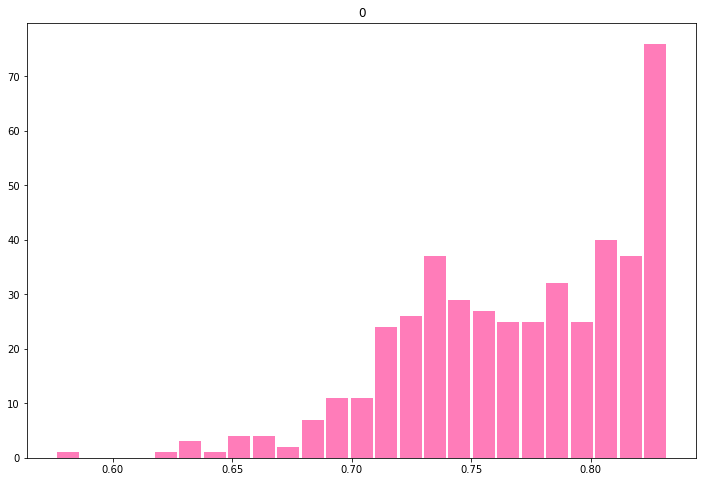

In [146]:
pd.DataFrame(JSD_S).hist(bins=25, grid=False, figsize=(12,8), color=char_colors[0], zorder=2, rwidth=0.9)

a= pd.DataFrame(JSD_S)
a = a.fillna(0)
group_values_S = {
    '<0.6': len(a[a[0]<0.6]),
    '0.6 < x < 0.7': len(a[(a[0]>=0.6) & (a[0]<0.7)]),
    '0.7 < x < 0.8': len(a[(a[0]>=0.7) & (a[0]<0.8)]),
    '0.8 < x < 0.9': len(a[(a[0]>=0.8) & (a[0]<0.9)]),
    '0.9 < x < 1': len(a[(a[0]>=0.9) & (a[0]<1)]),
    '> 1': len(a[(a[0]>=1)])
}

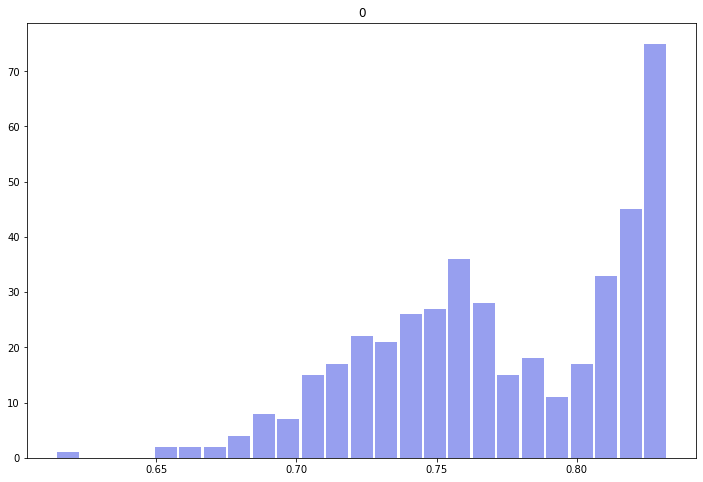

In [147]:
pd.DataFrame(JSD_N).hist(bins=25, grid=False, figsize=(12,8), color=char_colors[1], zorder=2, rwidth=0.9)
b = pd.DataFrame(JSD_N)
b = b.fillna(0)
group_values_NS = {
    '<0.6': len(b[b[0]<0.6]),
    '0.6 < x < 0.7': len(b[(b[0]>=0.6) & (b[0]<0.7)]),
    '0.7 < x < 0.8': len(b[(b[0]>=0.7) & (b[0]<0.8)]),
    '0.8 < x < 0.9': len(b[(b[0]>=0.8) & (b[0]<0.9)]),
    '0.9 < x < 1': len(b[(b[0]>=0.9) & (b[0]<1)]),
    '> 1': len(b[(b[0]>=1)])
}

## Votes

In [107]:
try:
    votes_per_user = pd.read_csv('data/votes-per-user.csv')
except:
    print('Retrieving from original database...')
    votes_per_user = pd.read_sql_query('''
    with q as (
        select v.vote_id,
           c.comment_id,
           v.user_id,
           v.gender,
           date_part('year',age(v.birth)) as age,
           c.content,
           v.vote,
           v.avg as label
    from comments c
             join (select v1.comment_id,
                          r.avg,
                          v1.vote_id,
                          v1.user_id,
                          v1.vote,
                          v1.gender,
                          v1.birth
                   from (
                        select v2.user_id,v2.vote,v2.vote_id, u.gender,v2.comment_id, u.birth
                        from votes v2 join users u on v2.user_id = u.username
                       ) v1 join results r on v1.comment_id = r.comment_id) v on c.comment_id = v.comment_id
    )
    select * from q;
    ''', conn)
    votes_per_user.to_csv('data/votes-per-user.csv', index=False)

In [108]:
votes_per_user.head(5)

,vote_id,comment_id,user_id,gender,age,content,vote,label
0,5972,790,mluisapbraga@gmail.com,fem,22.0,Perfeito!,0,0.333333
1,1652,790,yv.sv45@gmail.com,masc,22.0,Perfeito!,0,0.333333
2,754,790,bragadeoliveiraaa@gmail.com,fem,20.0,Perfeito!,1,0.333333
3,4298,2850,roberto.sousa@fpf.br,masc,31.0,"Impressão sua, a diferença é que agora você vê...",0,0.500000
4,1086,2850,alexandrehsilva96@gmail.com,masc,23.0,"Impressão sua, a diferença é que agora você vê...",1,0.500000


In [109]:
age_list = list(votes_per_user.age.unique())
age_list.sort()

qtd_votes_per_age = dict({})

qtd_female_votes_per_age = dict({})
qtd_sexist_female_votes_per_age = dict({})
qtd_not_sexist_female_votes_per_age = dict({})

qtd_correct_sexist_female_votes_per_age = dict({})
qtd_correct_not_sexist_female_votes_per_age = dict({})
qtd_incorrect_sexist_female_votes_per_age = dict({})
qtd_incorrect_not_sexist_female_votes_per_age = dict({})

qtd_male_votes_per_age = dict({})
qtd_sexist_male_votes_per_age = dict({})
qtd_not_sexist_male_votes_per_age = dict({})

qtd_correct_sexist_male_votes_per_age = dict({})
qtd_correct_not_sexist_male_votes_per_age = dict({})
qtd_incorrect_sexist_male_votes_per_age = dict({})
qtd_incorrect_not_sexist_male_votes_per_age = dict({})

for age in age_list:
  qtd_votes_per_age[age] = votes_per_user[votes_per_user['age']==age].shape[0]
for age in age_list:
  qtd_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem')].shape[0]
for age in age_list:
  qtd_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc')].shape[0]

for age in age_list:
  qtd_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1)].shape[0]
for age in age_list:
  qtd_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0)].shape[0]

for age in age_list:
  qtd_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1)].shape[0]
for age in age_list:
  qtd_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0)].shape[0]

for age in age_list:
  qtd_correct_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_correct_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0) & (votes_per_user['label']<0.5)].shape[0]
for age in age_list:
  qtd_incorrect_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==0) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_incorrect_not_sexist_female_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='fem') & (votes_per_user['vote']==1) & (votes_per_user['label']<0.5)].shape[0]

for age in age_list:
  qtd_correct_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_correct_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0) & (votes_per_user['label']<0.5)].shape[0]
for age in age_list:
  qtd_incorrect_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==0) & (votes_per_user['label']>0.5)].shape[0]
for age in age_list:
  qtd_incorrect_not_sexist_male_votes_per_age[age] = votes_per_user[(votes_per_user['age']==age) & (votes_per_user['gender']=='masc') & (votes_per_user['vote']==1) & (votes_per_user['label']<0.5)].shape[0]

## Charts

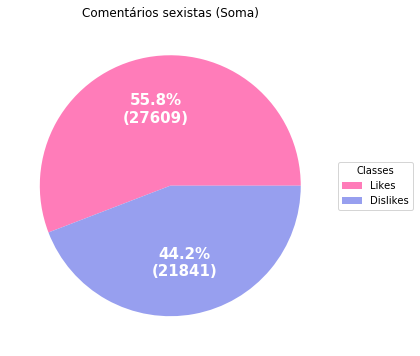

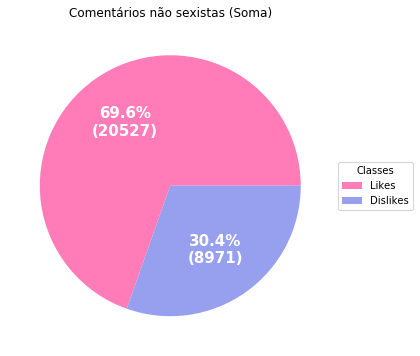

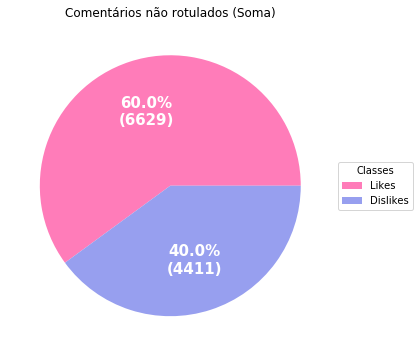

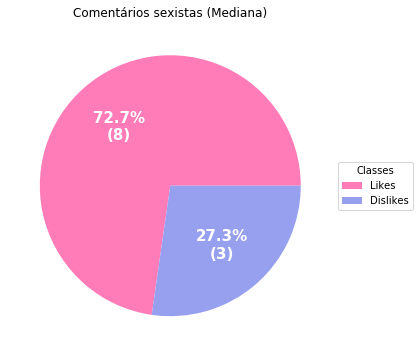

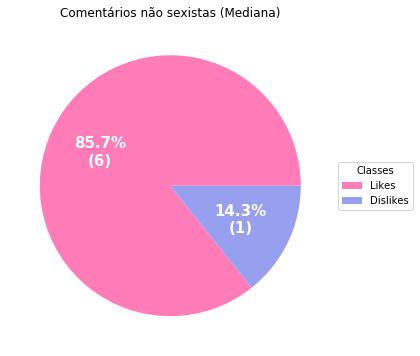

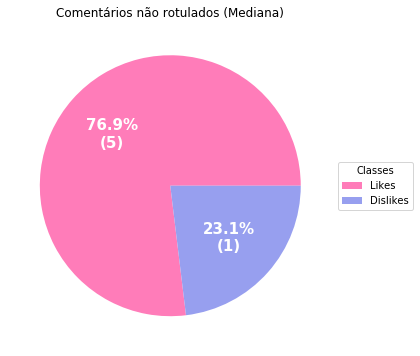

In [110]:
plot_pizza('Comentários sexistas (Soma)',['Likes','Dislikes'],[temp_comments.get('sexist').get('likes_qty'),temp_comments.get('sexist').get('dislikes_qty')])
plot_pizza('Comentários não sexistas (Soma)',['Likes','Dislikes'],[temp_comments.get('not_sexist').get('likes_qty'),temp_comments.get('not_sexist').get('dislikes_qty')])
plot_pizza('Comentários não rotulados (Soma)',['Likes','Dislikes'],[temp_comments.get('undefined').get('likes_qty'),temp_comments.get('undefined').get('dislikes_qty')])
plot_pizza('Comentários sexistas (Mediana)',['Likes','Dislikes'],[temp_comments.get('sexist').get('likes_qty_median'),temp_comments.get('sexist').get('dislikes_qty_median')])
plot_pizza('Comentários não sexistas (Mediana)',['Likes','Dislikes'],[temp_comments.get('not_sexist').get('likes_qty_median'),temp_comments.get('not_sexist').get('dislikes_qty_median')])
plot_pizza('Comentários não rotulados (Mediana)',['Likes','Dislikes'],[temp_comments.get('undefined').get('likes_qty_median'),temp_comments.get('undefined').get('dislikes_qty_median')])

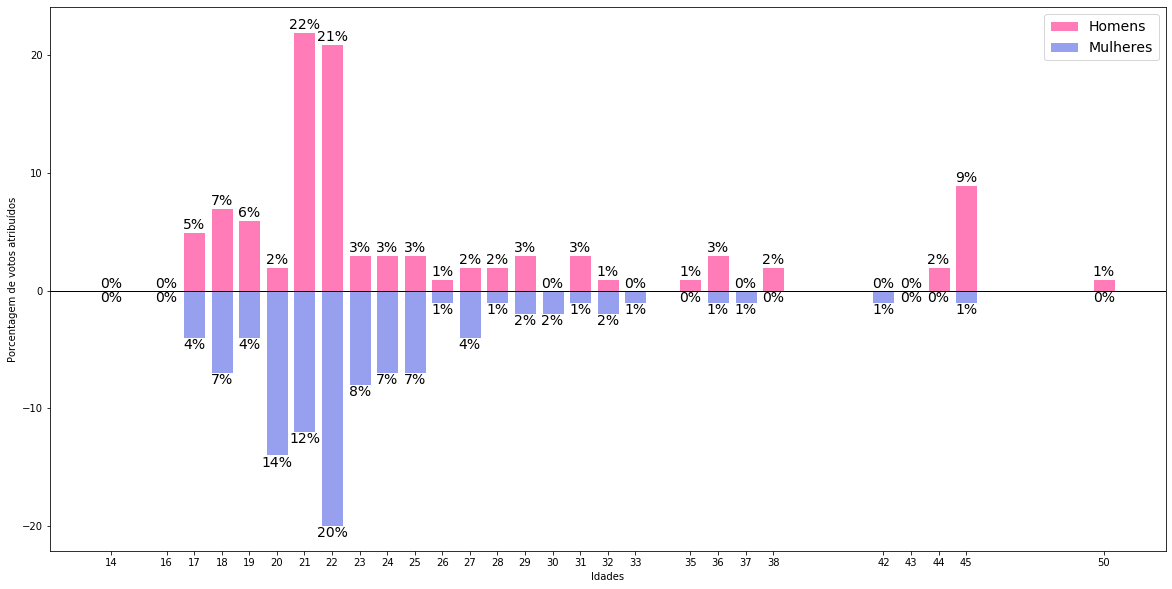

In [130]:
# corretos-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_correct_sexist_male_votes_per_age),
               normalize_dict(qtd_correct_sexist_female_votes_per_age),
               age_list)

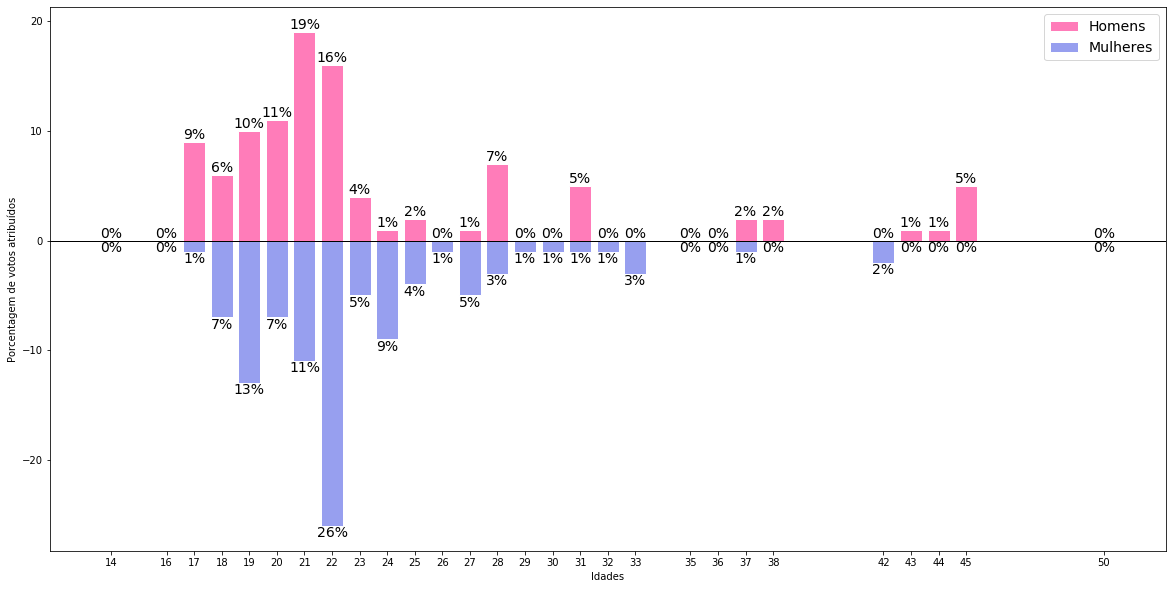

In [131]:
# incorretos-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_incorrect_sexist_male_votes_per_age),
               normalize_dict(qtd_incorrect_sexist_female_votes_per_age),
               age_list)

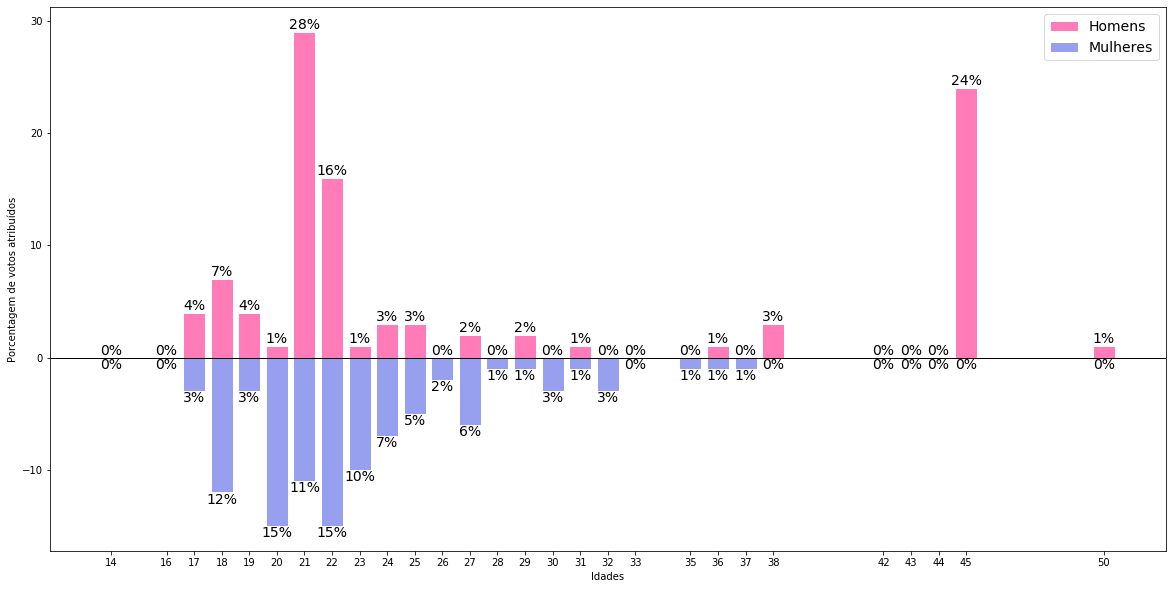

In [132]:
# incorretos-nao-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_incorrect_not_sexist_male_votes_per_age),
               normalize_dict(qtd_incorrect_not_sexist_female_votes_per_age),
               age_list)

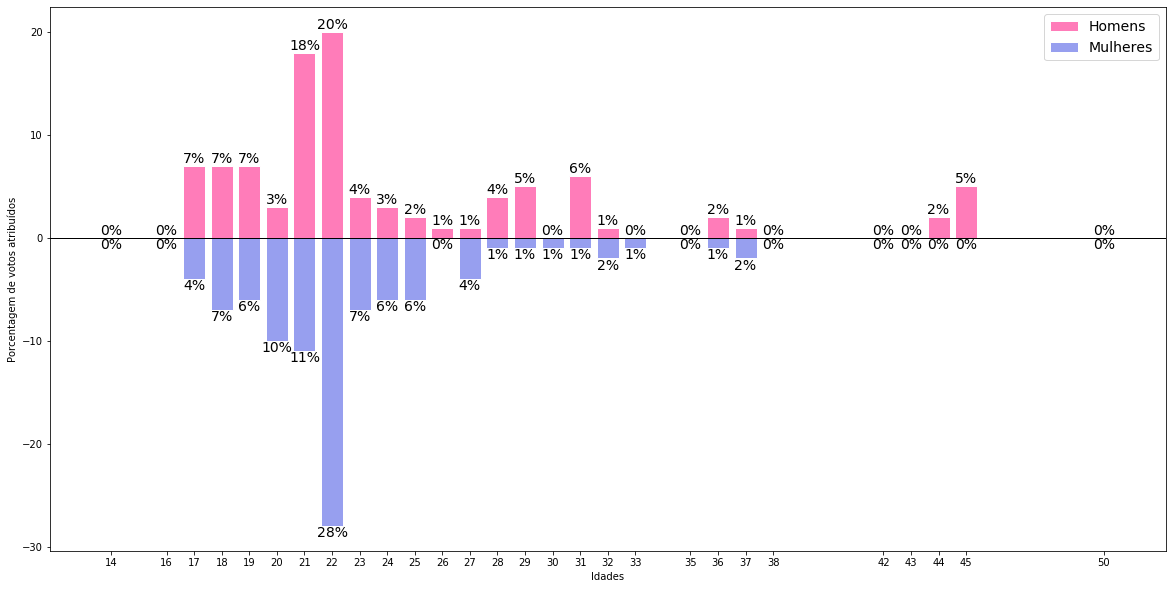

In [133]:
# corretos-nao-sexista-genero-idade
doublebar_plot(normalize_dict(qtd_correct_not_sexist_male_votes_per_age),
               normalize_dict(qtd_correct_not_sexist_female_votes_per_age),
               age_list)

## SVM

In [158]:
tf_relevant_sexist_words = relevant_sexist_words[0:101]

sexist_vectorizer = TfidfVectorizer(
    stop_words=[],
#     use_idf=True,
)
not_sexist_vectorizer = TfidfVectorizer(
    stop_words=[],
#     use_idf=True,
)

sexist_doc = sexist_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))
not_sexist_doc = not_sexist_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))
undefined_doc = undefined_comments['content'].apply(lambda y: ' '.join([x for x in y.split() if x in tf_relevant_sexist_words]))

sexist_tfidf = sexist_vectorizer.fit_transform(sexist_doc).toarray()
not_sexist_tfidf = not_sexist_vectorizer.fit_transform(not_sexist_doc).toarray()

sexist_tfidf_df = pd.DataFrame(sexist_tfidf)
not_sexist_tfidf_df = pd.DataFrame(not_sexist_tfidf)
sexist_y = sexist_comments['avg'].apply(lambda x: 1)
not_sexist_y = not_sexist_comments['avg'].apply(lambda x: 0)
y_df = np.array(pd.concat([sexist_y, not_sexist_y]))
dataframe = pd.concat([sexist_tfidf_df, not_sexist_tfidf_df]).fillna(0)
dataframe['sexist'] = y_df

dataframe = dataframe.sample(frac=1)

colunas = list(dataframe.columns)
colunas = colunas[:len(colunas)-1]
dataframe[colunas]

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
352,0.000000,0.323414,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.381874,0.0
210,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
258,0.000000,0.000000,0.0,0.0,0.0,0.0,0.452996,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
141,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
762,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
378,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
885,0.550221,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.265556,0.0,0.0,0.0,0.000000,0.0
714,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [159]:
dataframe = dataframe.sample(frac=1)

colunas = list(dataframe.columns)
colunas = colunas[:len(colunas)-4]

X_df = dataframe[colunas]
y_df = dataframe['sexist']

total = dataframe.shape[0]
train_qty = int(total*0.9)

M = np.concatenate([X_df],axis=1)
X = pd.DataFrame(M)
y = y_df.astype(int)

X_train = X_df[:train_qty]
y_train = y_df[:train_qty]
X_test = X_df[train_qty:]
y_test = y_df[train_qty:]

### Grid Search

In [ ]:
from sklearn import svm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [ ]:
y_ = grid.predict(X_test)
report = classification_report( y_test, y_ )
print(report)